<a href="https://colab.research.google.com/github/Sathwick-Reddy-M/550-Research-Paper/blob/main/Research_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspellchecker langdetect

In [ ]:
from wordcloud import WordCloud
import numpy as np
import pandas as pd
import re
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
%cd "/content/drive/MyDrive/550/Research Paper/fnc-1/"

/content/drive/MyDrive/550/Research Paper/fnc-1


# Dataset Analysis

## Intial Data Insights

In [ ]:
# Load the data

train_bodies = pd.read_csv('train_bodies.csv')
train_stances = pd.read_csv('train_stances.csv')

In [ ]:
train_bodies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Body ID      1683 non-null   int64 
 1   articleBody  1683 non-null   object
dtypes: int64(1), object(1)
memory usage: 26.4+ KB


In [ ]:
train_stances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  49972 non-null  object
 1   Body ID   49972 non-null  int64 
 2   Stance    49972 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [ ]:
# Find duplicated articleBody entries
duplicate_article_bodies = train_bodies[train_bodies.duplicated(subset=['articleBody'], keep=False)]

# Extract duplicated articleBodies and their corresponding Body IDs
duplicated_data = train_bodies[train_bodies['articleBody'].isin(duplicate_article_bodies['articleBody'])]

print(len(duplicated_data.sort_values(by='articleBody')))
# Display duplicated articleBodies and their corresponding Body IDs
duplicated_data.sort_values(by='articleBody')

28


Body ID                                        articleBody
1292     1946  A Texas National Guard soldier scans the Mexic...
499       742  A Texas National Guard soldier scans the Mexic...
182       286  A rumor on Tuesday claims Apple's upcoming App...
971      1458  A rumor on Tuesday claims Apple's upcoming App...
1461     2201  Along with unveiling the Apple Watch earlier t...
1610     2419  Along with unveiling the Apple Watch earlier t...
28         41  Although Apple has given us our first peek at ...
1654     2485  Although Apple has given us our first peek at ...
854      1291  Apple is shifting its retail strategy for the ...
1366     2056  Apple is shifting its retail strategy for the ...
1518     2277  Apple took the leap into the wearable space wi...
190       300  Apple took the leap into the wearable space wi...
67        105  As Apple gears up to launch the Apple Watch in...
231       373  As Apple gears up to launch the Apple Watch in...
1512     2271  French Apple website iGen.fr is reporting [Goo...
379       577  French Apple website iGen.fr is reporting [Goo...
368       562  Investment firm Piper Jaffray issued a report ...
1389     2092  Investment firm Piper Jaffray issued a report ...
313       490  One passenger at Dulles International Airport ...
1209     1826  One passenger at Dulles International Airport ...
585       877  Piper Jaffray’s Gene Munster has issued a new ...
1478     2223  Piper Jaffray’s Gene Munster has issued a new ...
526       790  The Apple Watch will not be an accessory for y...
426       645  The Apple Watch will not be an accessory for y...
1455     2188  When Apple introduced its Apple Watch in Septe...
1574     2365  When Apple introduced its Apple Watch in Septe...
116       181  While Apple announced that the base model of i...
1320     1983  While Apple announced that the base model of i...

In [ ]:
print(len(train_stances[train_stances['Body ID'].isin([1946, 742])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([286, 1458])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([2201, 2419])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([41, 2485])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([1291, 2056])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([2277, 300])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([105, 373])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([2271, 577])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([562, 2092])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([490, 1826])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([877, 2223])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([790, 645])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([2188, 2365])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([181, 1983])]))

62, 79, 45, 9, 83, 34, 86, 9, 49, 81, 37, 10, 46, 52


In [ ]:
sum([62, 79, 45, 9, 83, 34, 86, 9, 49, 81, 37, 10, 46, 52])

682

In [ ]:
682-14, 49972-668

(668, 49304)

## Cleaning

In [ ]:
# Identify duplicated bodies
duplicate_bodies = train_bodies[train_bodies.duplicated(subset=['articleBody'], keep=False)]

# Group duplicated bodies by articleBody and assign unique IDs
unique_ids = {}
unique_id_counter = 10000
for _, group in duplicate_bodies.groupby('articleBody'):
    if group['articleBody'].iloc[0] not in unique_ids:
        unique_ids[group['articleBody'].iloc[0]] = unique_id_counter
        unique_id_counter += 1

# Assign unique IDs to the duplicated bodies
duplicate_bodies['unique_body_id'] = duplicate_bodies['articleBody'].map(unique_ids)

# Update the Body ID column in both datasets with the new unique IDs
for idx, row in duplicate_bodies.iterrows():
    train_bodies.loc[train_bodies['articleBody'] == row['articleBody'], 'Body ID'] = row['unique_body_id']
    train_stances.loc[train_stances['Body ID'] == row['Body ID'], 'Body ID'] = row['unique_body_id']

# Drop duplicate rows from both datasets
train_bodies_cleaned = train_bodies.drop_duplicates()
train_stances_cleaned = train_stances.drop_duplicates()

<ipython-input-82-b959a34085cf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicate_bodies['unique_body_id'] = duplicate_bodies['articleBody'].map(unique_ids)


In [ ]:
duplicate_bodies.sort_values(by='articleBody')

Body ID                                        articleBody  \
1292     1946  A Texas National Guard soldier scans the Mexic...   
499       742  A Texas National Guard soldier scans the Mexic...   
182       286  A rumor on Tuesday claims Apple's upcoming App...   
971      1458  A rumor on Tuesday claims Apple's upcoming App...   
1461     2201  Along with unveiling the Apple Watch earlier t...   
1610     2419  Along with unveiling the Apple Watch earlier t...   
28         41  Although Apple has given us our first peek at ...   
1654     2485  Although Apple has given us our first peek at ...   
854      1291  Apple is shifting its retail strategy for the ...   
1366     2056  Apple is shifting its retail strategy for the ...   
1518     2277  Apple took the leap into the wearable space wi...   
190       300  Apple took the leap into the wearable space wi...   
67        105  As Apple gears up to launch the Apple Watch in...   
231       373  As Apple gears up to launch the Apple Watch in...   
1512     2271  French Apple website iGen.fr is reporting [Goo...   
379       577  French Apple website iGen.fr is reporting [Goo...   
368       562  Investment firm Piper Jaffray issued a report ...   
1389     2092  Investment firm Piper Jaffray issued a report ...   
313       490  One passenger at Dulles International Airport ...   
1209     1826  One passenger at Dulles International Airport ...   
585       877  Piper Jaffray’s Gene Munster has issued a new ...   
1478     2223  Piper Jaffray’s Gene Munster has issued a new ...   
526       790  The Apple Watch will not be an accessory for y...   
426       645  The Apple Watch will not be an accessory for y...   
1455     2188  When Apple introduced its Apple Watch in Septe...   
1574     2365  When Apple introduced its Apple Watch in Septe...   
116       181  While Apple announced that the base model of i...   
1320     1983  While Apple announced that the base model of i...   

      unique_body_id  
1292           10000  
499            10000  
182            10001  
971            10001  
1461           10002  
1610           10002  
28             10003  
1654           10003  
854            10004  
1366           10004  
1518           10005  
190            10005  
67             10006  
231            10006  
1512           10007  
379            10007  
368            10008  
1389           10008  
313            10009  
1209           10009  
585            10010  
1478           10010  
526            10011  
426            10011  
1455           10012  
1574           10012  
116            10013  
1320           10013

## Row Counts and Values

In [ ]:
train_bodies_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1669 entries, 0 to 1682
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Body ID      1669 non-null   int64 
 1   articleBody  1669 non-null   object
dtypes: int64(1), object(1)
memory usage: 39.1+ KB


In [ ]:
train_bodies_cleaned.isnull().sum()

Body ID        0
articleBody    0
dtype: int64

In [ ]:
train_bodies_cleaned.nunique()

Body ID        1669
articleBody    1669
dtype: int64

In [ ]:
train_stances_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49538 entries, 0 to 49971
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  49538 non-null  object
 1   Body ID   49538 non-null  int64 
 2   Stance    49538 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [ ]:
train_stances_cleaned.isnull().sum()

Headline    0
Body ID     0
Stance      0
dtype: int64

In [ ]:
train_stances_cleaned.nunique()

Headline    1648
Body ID     1669
Stance         4
dtype: int64

In [ ]:
merged_data = pd.merge(train_stances_cleaned, train_bodies_cleaned, on='Body ID')

In [ ]:
len(unique_vals)

149

In [ ]:
# Other lang chars
unique_vals

array(['§', '©', '«', '\xad', '®', '°', '·', '»', 'Ó', 'à', 'á', 'â', 'ä',
       'æ', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ï', 'ñ', 'ó', 'ô', 'ö', 'ù',
       'ú', 'ü', 'ć', 'ē', 'ı', 'œ', 'М', 'Ч', 'а', 'в', 'г', 'д', 'е',
       'и', 'к', 'м', 'о', 'у', 'ч', 'я', 'א', 'ח', 'י', 'ן', 'ר', '،',
       'ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح',
       'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'ف',
       'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي', 'ً', 'ّ', '٢', '٣',
       'ḥ', '\u2003', '\u2009', '\u200b', '\u200e', '\u200f', '–', '―',
       '•', '…', '\u202a', '′', '″', '‼', '€', '™', '■', '☝', '❤', '⭕',
       '。', '〽', '不', '主', '刷', '回', '在', '多', '存', '已', '您', '所', '更',
       '查', '榜', '源', '理', '的', '看', '站', '网', '访', '请', '资', '返', '问',
       '页', '미', '타', '️', 'ﻷ', '\ufeff', '�', '🎃', '💀', '😂', '😱', '😳'],
      dtype='<U1')

In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49538 entries, 0 to 49537
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headline     49538 non-null  object
 1   Body ID      49538 non-null  int64 
 2   Stance       49538 non-null  object
 3   articleBody  49538 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


In [ ]:
merged_data.isnull().sum()

Headline       0
Body ID        0
Stance         0
articleBody    0
dtype: int64

In [ ]:
merged_data.nunique()

Headline       1648
Body ID        1669
Stance            4
articleBody    1669
dtype: int64

In [ ]:
# Find the number of distinct Headline and BodyID
num_distinct_headlines = merged_data['Headline'].nunique()
num_distinct_body_ids = merged_data['Body ID'].nunique()

# Print the results
print("Number of distinct Headlines:", num_distinct_headlines)
print("Number of distinct Body IDs:", num_distinct_body_ids)

Number of distinct Headlines: 1648
Number of distinct Body IDs: 1669


In [ ]:
# Calculate the distribution of stance classes
stance_counts = merged_data['Stance'].value_counts()
stance_distribution = stance_counts / stance_counts.sum()

# Combine original counts and normalized counts into a DataFrame
distribution_df = pd.concat([stance_counts, stance_distribution], axis=1)
distribution_df.columns = ['Original Counts', 'Normalized Counts']

# Print the distribution
print("Stance Distribution:")
print(distribution_df)

Stance Distribution:
           Original Counts  Normalized Counts
Stance                                       
unrelated            36262           0.732004
discuss               8804           0.177722
agree                 3643           0.073540
disagree               829           0.016735


In [ ]:
# Define a regex pattern to match any character that is not a letter or whitespace
pattern = r'[^a-zA-Z\s]'

# Filter the dataframe to get distinct headlines that match the pattern
distinct_headlines_with_numbers_or_special_chars = merged_data[merged_data['Headline'].str.contains(pattern)]['Headline'].unique()

# Print the distinct headlines
print("Distinct Headlines containing numbers or special characters:", len(distinct_headlines_with_numbers_or_special_chars))
print(distinct_headlines_with_numbers_or_special_chars)

Distinct Headlines containing numbers or special characters: 1300
["Police find mass graves with at least '15 bodies' near Mexico town where 43 students disappeared after police clash"
 'Seth Rogen to Play Apple’s Steve Wozniak'
 'Mexico police find mass grave near site 43 students vanished' ...
 'Apple is limiting features on the Apple Watch to save battery life, according to developers'
 'Mom Calls 911 On Masturbating Teenage Son; Boy Arrested, Charged With New ‘Self-Rape’ State Law'
 "Sushi lover's entire body left riddled with WORMS after eating contaminated sashimi"]


In [ ]:
# Define a regex pattern to match any character that is not a letter or whitespace
pattern = r'[^a-zA-Z\s]'

# Filter the dataframe to get distinct bodies that match the pattern
distinct_bodies_with_numbers_or_special_chars = merged_data[merged_data['articleBody'].str.contains(pattern)]['articleBody'].unique()

# Print the distinct bodies
print("Distinct Bodies containing numbers or special characters:", len(distinct_bodies_with_numbers_or_special_chars))
print(distinct_bodies_with_numbers_or_special_chars)

Distinct Bodies containing numbers or special characters: 1666
['Danny Boyle is directing the untitled film\r\n\r\nSeth Rogen is being eyed to play Apple co-founder Steve Wozniak in Sony’s Steve Jobs biopic.\r\n\r\nDanny Boyle is directing the untitled film, based on Walter Isaacson\'s book and adapted by Aaron Sorkin, which is one of the most anticipated biopics in recent years.\r\n\r\nNegotiations have not yet begun, and it’s not even clear if Rogen has an official offer, but the producers — Scott Rudin, Guymon Casady and Mark Gordon — have set their sights on the talent and are in talks.\r\n\r\nOf course, this may all be for naught as Christian Bale, the actor who is to play Jobs, is still in the midst of closing his deal. Sources say that dealmaking process is in a sensitive stage.\r\n\r\nInsiders say Boyle will is flying to Los Angeles to meet with actress to play one of the female leads, an assistant to Jobs. Insiders say that Jessica Chastain is one of the actresses on the meeti

It's better not remove the digits because they hold the meaning some of the headlines. But we can just ignore the special characters anyway because they don't help much in the identification of the relation between the headline and body

## Analysing the Merged Data

In [ ]:
merged_data.head()

Headline  Body ID     Stance  \
0  Police find mass graves with at least '15 bodi...      712  unrelated   
1           Seth Rogen to Play Apple’s Steve Wozniak      712    discuss   
2  Mexico police find mass grave near site 43 stu...      712  unrelated   
3  Mexico Says Missing Students Not Found In Firs...      712  unrelated   
4  New iOS 8 bug can delete all of your iCloud do...      712  unrelated   

                                         articleBody  
0  Danny Boyle is directing the untitled film\r\n...  
1  Danny Boyle is directing the untitled film\r\n...  
2  Danny Boyle is directing the untitled film\r\n...  
3  Danny Boyle is directing the untitled film\r\n...  
4  Danny Boyle is directing the untitled film\r\n...

### Body ID


Body IDs with the Highest Number of Associated Articles:
Body ID: 1921, Number of Articles: 184

Body IDs with the Lowest Number of Associated Articles:
Body ID: 136, Number of Articles: 1
Body ID: 464, Number of Articles: 1
Body ID: 907, Number of Articles: 1
Body ID: 112, Number of Articles: 1
Body ID: 200, Number of Articles: 1
Body ID: 915, Number of Articles: 1
Body ID: 76, Number of Articles: 1
Body ID: 362, Number of Articles: 1
Body ID: 476, Number of Articles: 1
Body ID: 307, Number of Articles: 1
Body ID: 285, Number of Articles: 1
Body ID: 407, Number of Articles: 1
Body ID: 1542, Number of Articles: 1
Body ID: 553, Number of Articles: 1
Body ID: 74, Number of Articles: 1
Body ID: 175, Number of Articles: 1
Body ID: 135, Number of Articles: 1
Body ID: 151, Number of Articles: 1
Body ID: 355, Number of Articles: 1
Body ID: 282, Number of Articles: 1
Body ID: 323, Number of Articles: 1
Body ID: 110, Number of Articles: 1
Body ID: 302, Number of Articles: 1
Body ID: 797, Numbe

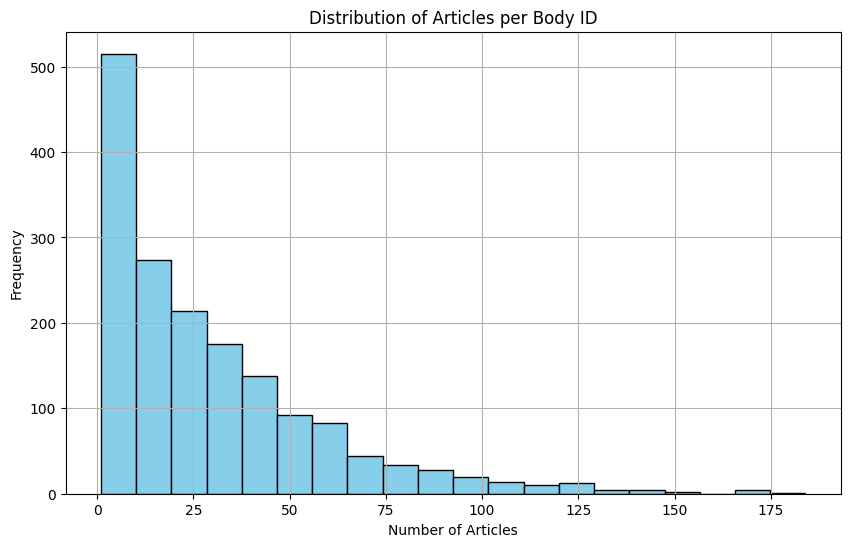

In [ ]:
import matplotlib.pyplot as plt

# Calculate the number of articles associated with each Body ID
articles_per_body_id = merged_data['Body ID'].value_counts()

# Find the maximum and minimum number of articles
max_articles_count = articles_per_body_id.max()
min_articles_count = articles_per_body_id.min()

# Find Body IDs with the maximum and minimum number of articles
max_articles_body_ids = articles_per_body_id[articles_per_body_id == max_articles_count]
min_articles_body_ids = articles_per_body_id[articles_per_body_id == min_articles_count]

# Print Body IDs with the maximum number of articles
print("\nBody IDs with the Highest Number of Associated Articles:")
for body_id, count in max_articles_body_ids.items():
    print(f"Body ID: {body_id}, Number of Articles: {count}")

# Print Body IDs with the minimum number of articles
print("\nBody IDs with the Lowest Number of Associated Articles:")
for body_id, count in min_articles_body_ids.items():
    print(f"Body ID: {body_id}, Number of Articles: {count}")


# Plot the Distribution of the Number of Articles per Body ID
plt.figure(figsize=(10, 6))
articles_per_body_id.plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Articles')
plt.ylabel('Frequency')
plt.title('Distribution of Articles per Body ID')
plt.grid(True)
plt.show()


Frequency Distribution: The histogram values show that there are 515 body IDs associated with approximately 1-10 articles, making this the most common range. As the number of articles per body increases, the frequency decreases.

Variability in Article Counts: There is significant variability in the number of articles associated with each body, as indicated by the spread of values across the histogram bins.

Long Tail: The histogram has a right-skewed distribution, with fewer body IDs having a large number of associated articles. This suggests that while some bodies have a high number of associated articles, most bodies have relatively few.

Sparse Distribution: Towards the right end of the histogram, there are bins with very few or no body IDs. This indicates that only a few bodies have a very high number of associated articles, and such cases are relatively rare.

Bin Range Interpretation: Each bin in the histogram represents a range of article counts associated with body IDs. For example, the bin from 1 to approximately 10.15 represents body IDs associated with 1-10 articles.

In [ ]:
merged_data['Body ID'].value_counts()

Body ID
1921    184
1948    173
40      171
524     170
1549    166
       ... 
44        1
18        1
1025      1
515       1
1066      1
Name: count, Length: 1669, dtype: int64

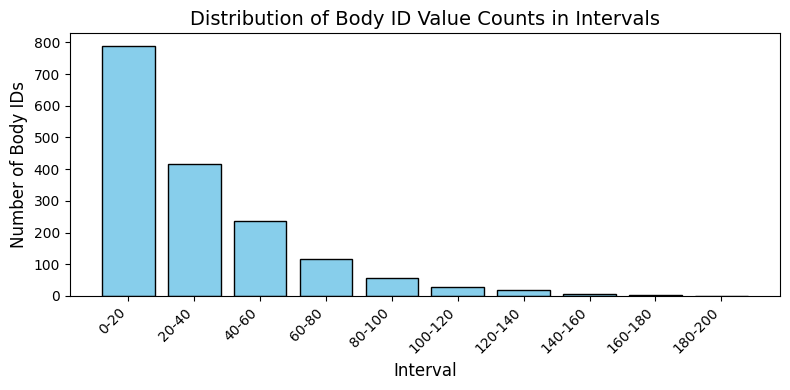

In [ ]:
# X-Axis - Range for Value Counts Y-Axis - Number of Body_ids (count) fall in that range

import matplotlib.pyplot as plt

# Define intervals for value counts
interval_size = 20
max_count = merged_data['Body ID'].value_counts().max()
num_intervals = max_count // interval_size + 1
intervals = [(i * interval_size, (i + 1) * interval_size) for i in range(num_intervals)]

# Count how many Body IDs fall into each interval
body_id_counts = merged_data['Body ID'].value_counts()
counts_in_intervals = [((body_id_counts >= interval[0]) & (body_id_counts < interval[1])).sum() for interval in intervals]

# Plot the distribution of Body ID counts in intervals
plt.figure(figsize=(8, 4))  # Set smaller figure size here
plt.bar(range(num_intervals), counts_in_intervals, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Interval', fontsize=12)
plt.ylabel('Number of Body IDs', fontsize=12)
plt.title('Distribution of Body ID Value Counts in Intervals', fontsize=14)
plt.xticks(range(num_intervals), [f'{interval[0]}-{interval[1]}' for interval in intervals], rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
counts_in_intervals

[821, 405, 229, 106, 47, 30, 13, 5, 3]

### Stance

In [ ]:
merged_data.groupby('Stance').size()

Stance
agree         3643
disagree       829
discuss       8804
unrelated    36262
dtype: int64

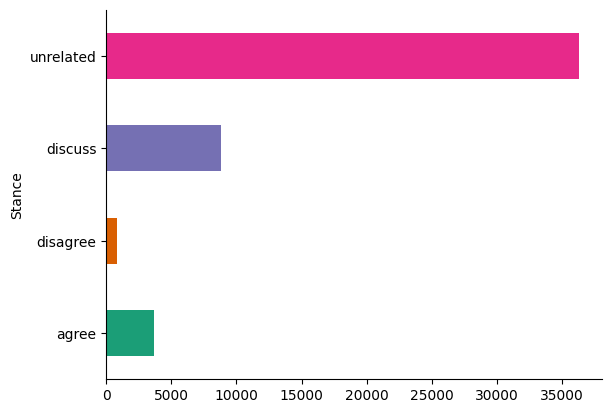

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
merged_data.groupby('Stance').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)


The dataset encompasses stance annotations categorized into four types: 'agree', 'disagree', 'discuss', and 'unrelated'. The 'unrelated' stances constitute the majority with 36,262 instances, representing approximately 73.01% of the total. Following closely, 'discuss' stances account for 8,804 instances, making up around 17.69% of the dataset. 'Agree' and 'disagree' stances are relatively less frequent, with 3,643 and 829 instances respectively, comprising approximately 7.33% and 1.67% of the dataset respectively.

### Word Count Analysis

For unique Article Bodies and unique Article Headlines

Word Count Distribution for Headlines:
count    1648.000000
mean       12.611650
std         4.770346
min         2.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        45.000000
dtype: float64

Word Count Distribution for Article Bodies:
count    1669.000000
mean      425.249850
std       344.971848
min         4.000000
25%       224.000000
50%       349.000000
75%       525.000000
max      5358.000000
dtype: float64

Summary Statistics for Headline Word Counts:
Mean: 12.611650485436893
Median: 12.0
Minimum: 2
Maximum: 45

Summary Statistics for Article Body Word Counts:
Mean: 425.24985020970644
Median: 349.0
Minimum: 4
Maximum: 5358


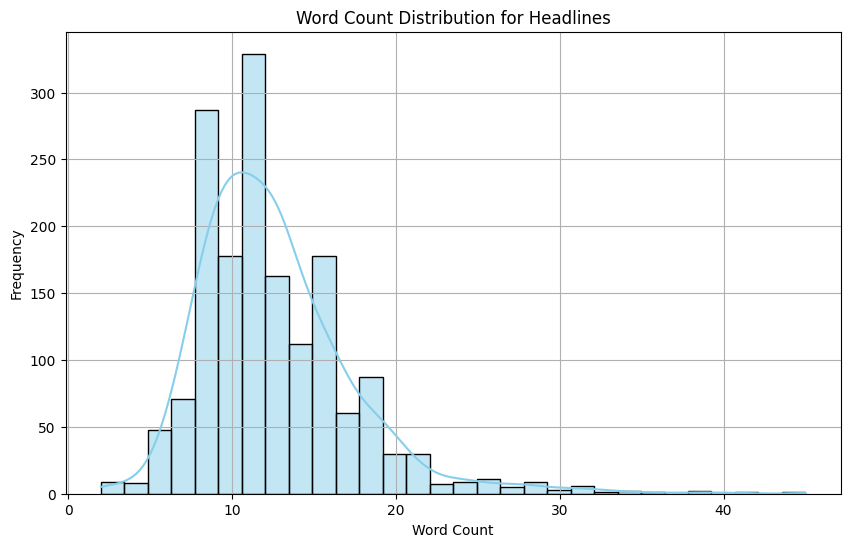

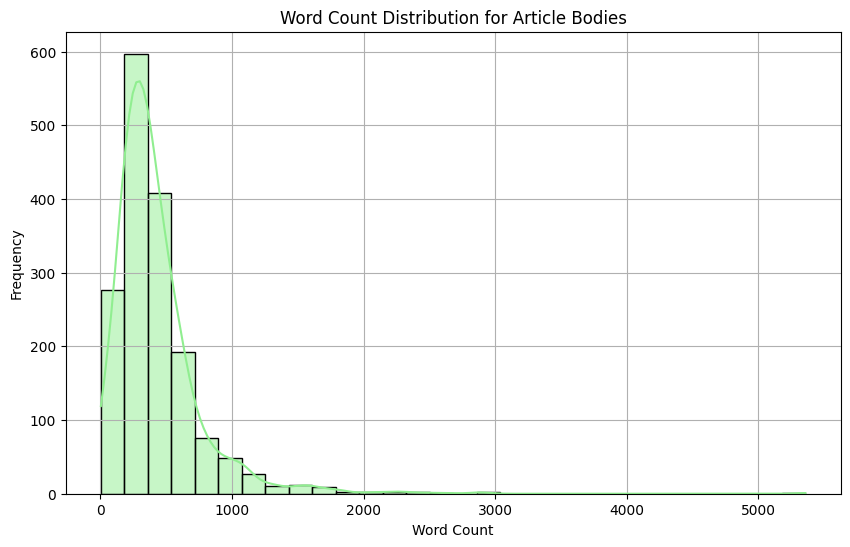

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize

# Tokenize text and calculate word counts for headlines and article bodies
headline_word_count = pd.Series(merged_data['Headline'].unique()).apply(lambda x: len(word_tokenize(x)))
body_word_count = pd.Series(merged_data['articleBody'].unique()).apply(lambda x: len(word_tokenize(x)))

# Analyze distribution of word counts for headlines and article bodies
print("Word Count Distribution for Headlines:")
print(headline_word_count.describe())

print("\nWord Count Distribution for Article Bodies:")
print(body_word_count.describe())

# Calculate summary statistics for word counts
headline_stats = {
    'Mean': headline_word_count.mean(),
    'Median': headline_word_count.median(),
    'Minimum': headline_word_count.min(),
    'Maximum': headline_word_count.max()
}

body_stats = {
    'Mean': body_word_count.mean(),
    'Median': body_word_count.median(),
    'Minimum': body_word_count.min(),
    'Maximum': body_word_count.max()
}

print("\nSummary Statistics for Headline Word Counts:")
for stat, value in headline_stats.items():
    print(f"{stat}: {value}")

print("\nSummary Statistics for Article Body Word Counts:")
for stat, value in body_stats.items():
    print(f"{stat}: {value}")

# Visualize distributions of word counts using histograms
plt.figure(figsize=(10, 6))
sns.histplot(data=headline_word_count, bins=30, color='skyblue', kde=True)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution for Headlines')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=body_word_count, bins=30, color='lightgreen', kde=True)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution for Article Bodies')
plt.grid(True)
plt.show()

**Headline Word Count**

Distribution Shape: The histogram and KDE plot illustrate a distribution of word counts for headlines that is right-skewed, indicating that most headlines tend to have fewer words, with a long tail towards higher word counts. This suggests that concise headlines are more common in the dataset.

Peak Word Count Range: The majority of headlines may have word counts ranging from approximately 5 to 20 words, as evidenced by the higher density of values in this range. This indicates that headlines in the dataset are typically short and to the point.

Rare High Word Counts: While most headlines have relatively low word counts, there are some headlines with word counts exceeding 30 words, although these instances are less common. This suggests the presence of longer, potentially more descriptive headlines in the dataset, although they are not as prevalent.

Mode of the Distribution: The mode of the distribution appears to be around 8 to 10 words, as indicated by the highest frequency of word counts in this range. This suggests that a significant portion of the headlines may fall within this word count range.

Spread of Word Counts: Similar to bodies, the spread of word counts for headlines varies, with some being very concise (2-5 words) while others are slightly longer (15+ words). This variability suggests a diverse range of headline lengths and styles within the dataset.

**Body Word Count**

**Distribution Shape**: The histogram and KDE plot illustrate a distribution of word counts for bodies that is likely right-skewed, similar to the distribution observed for headlines. This indicates that most bodies tend to have fewer words, with a long tail towards higher word counts.

**Peak Word Count Range**: The majority of bodies may have word counts ranging from approximately 100 to 500 words, as evidenced by the higher density of values in this range. This suggests that the bodies in the dataset are typically of moderate length.

**Rare High Word Counts**: While most bodies have relatively moderate word counts, there are some bodies with word counts exceeding 1000 words, although these instances are less common. This indicates the presence of longer, more detailed bodies within the dataset.

**Mode of the Distribution**: The mode of the distribution appears to be around 200 to 300 words, as indicated by the highest frequency of word counts in this range. This suggests that a significant portion of the bodies may fall within this word count range.

**Spread of Word Counts**: Similar to headlines, the spread of word counts for bodies varies, with some being very concise (50-100 words) while others are more extensive (500+ words). This variability suggests a diverse range of body lengths and styles within the dataset.

### Text Analysis



For the whole merged data

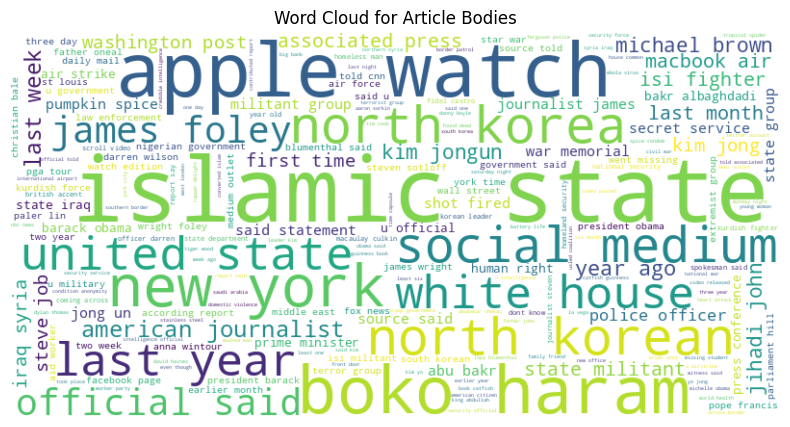

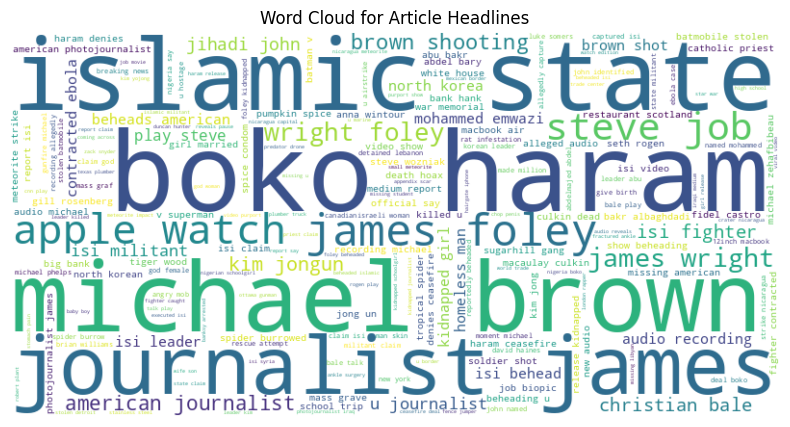

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter, defaultdict
import pandas as pd
import re
from spellchecker import SpellChecker

from nltk.corpus import wordnet

def is_word_in_wordnet(word):
    synsets = wordnet.synsets(word)
    return len(synsets) > 0

# Function to remove links from text
def remove_links(text):
    # Remove email addresses
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
    # Remove phone numbers
    text = re.sub(r'\b(?:\d{3}[-.\s]?)?\d{3}[-.\s]?\d{4}\b', '', text)
    return re.sub(r'http\S+', '', text)

# Function to remove punctuation
def remove_punctuation(text):
    text = re.sub(r'\r\n\r\n', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return re.sub(r'[^\w\s]', '', text)


invalid_char_removal = defaultdict(lambda: [])

def remove_invalid_chars(text):
    result = ""
    for i in text:
      if not i.isalnum() and i != ' ':
        continue
      result += i
    if(len(result) != len(text)):
      invalid_char_removal[text].append(result)
    return result

# Function to perform spell correction
spell_correction = defaultdict(lambda: [])
def correct_spelling(text):
    spell = SpellChecker()
    corrected_text = []
    for word in text:
        corrected_word = spell.correction(word)
        corrected_text.append(corrected_word)
        if(word != corrected_word):
            spell_correction[word].append(corrected_word)
    return corrected_text

# Tokenization, removing stop words, lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Create a dictionary to store tokenized bodies for efficient reuse
tokenized_bodies_dict = {}

def preprocess_text(text):
    text = remove_links(text)
    text = remove_punctuation(text)
    text = remove_invalid_chars(text)
    tokens = word_tokenize(text.lower())  # Tokenization and convert to lowercase
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token not in stop_words]  # Remove stop words and lemmatization
    # tokens = correct_spelling(tokens) # Spell correction
    return tokens

def get_tokenized_body(body_id, body_text):
    if body_id in tokenized_bodies_dict:
        return tokenized_bodies_dict[body_id]
    else:
        tokenized_body = preprocess_text(body_text)
        tokenized_bodies_dict[body_id] = tokenized_body
        return tokenized_body

tokenized_headlines_dict = {}

def get_tokenized_headline(headline):
    if headline in tokenized_headlines_dict:
        return tokenized_headlines_dict[headline]
    else:
        tokenized_headline = preprocess_text(headline)
        tokenized_headlines_dict[headline] = tokenized_headline
        return tokenized_headline

merged_data['body_tokens'] = merged_data.apply(lambda row: get_tokenized_body(row['Body ID'], row['articleBody']), axis=1)
merged_data['headline_tokens'] = merged_data['Headline'].apply(get_tokenized_headline)

# Function to get the token count
def get_token_count(tokens):
    return len(tokens)

# Apply the token count function to each row
merged_data['body_token_count'] = merged_data['body_tokens'].apply(get_token_count)
merged_data['headline_token_count'] = merged_data['headline_tokens'].apply(get_token_count)


# Analyze most frequent words
def analyze_most_frequent_words(tokens):
    word_freq = Counter(tokens)
    most_common_words = word_freq.most_common(10)
    return most_common_words

# Get most frequent words for bodies
body_most_common_words = analyze_most_frequent_words([word for sublist in merged_data['body_tokens'] for word in sublist])
headline_most_common_words = analyze_most_frequent_words([word for sublist in merged_data['headline_tokens'] for word in sublist])

In [ ]:
visualize_word_cloud(merged_data['body_tokens'].sum(), title="Test")

In [ ]:
headline_most_common_words

[('isi', 7667),
 ('u', 3848),
 ('report', 3589),
 ('say', 3551),
 ('claim', 3404),
 ('foley', 3222),
 ('james', 3123),
 ('video', 3077),
 ('michael', 2969),
 ('journalist', 2954)]

In [ ]:
body_most_common_words

[('said', 132570),
 ('one', 43241),
 ('video', 42792),
 ('state', 42466),
 ('report', 40559),
 ('apple', 39779),
 ('u', 39597),
 ('would', 36074),
 ('time', 35822),
 ('also', 35684)]

In [ ]:
merged_data

Headline  Body ID     Stance  \
0      Police find mass graves with at least '15 bodi...      712  unrelated   
1               Seth Rogen to Play Apple’s Steve Wozniak      712    discuss   
2      Mexico police find mass grave near site 43 stu...      712  unrelated   
3      Mexico Says Missing Students Not Found In Firs...      712  unrelated   
4      New iOS 8 bug can delete all of your iCloud do...      712  unrelated   
...                                                  ...      ...        ...   
49533  Amazon Is Opening a Brick-and-Mortar Store in ...      464      agree   
49534  Elon University has not banned the term ‘fresh...      362      agree   
49535  Fake BBC News website set up to carry Charlie ...      915      agree   
49536  Apple was forced to nix key health features fr...      407    discuss   
49537  If you want an Apple Watch, you’ll probably be...     1066    discuss   

                                             articleBody  \
0      Danny Boyle is directing the untitled film\r\n...   
1      Danny Boyle is directing the untitled film\r\n...   
2      Danny Boyle is directing the untitled film\r\n...   
3      Danny Boyle is directing the untitled film\r\n...   
4      Danny Boyle is directing the untitled film\r\n...   
...                                                  ...   
49533  Amazon, the cyber store that sells everything,...   
49534  ELON, N.C. – A recent rumor claims that Elon U...   
49535  A realistic-looking fake BBC News website has ...   
49536  The health-focused smartwatch that Apple initi...   
49537  We still don’t know the exact date the Apple W...   

                                             body_tokens  \
0      [danny, boyle, directing, untitled, film, seth...   
1      [danny, boyle, directing, untitled, film, seth...   
2      [danny, boyle, directing, untitled, film, seth...   
3      [danny, boyle, directing, untitled, film, seth...   
4      [danny, boyle, directing, untitled, film, seth...   
...                                                  ...   
49533  [amazon, cyber, store, sell, everything, plan,...   
49534  [elon, nc, recent, rumor, claim, elon, univers...   
49535  [realisticlooking, fake, bbc, news, website, s...   
49536  [healthfocused, smartwatch, apple, initially, ...   
49537  [still, dont, know, exact, date, apple, watch,...   

                                         headline_tokens  body_token_count  \
0      [police, find, mass, graf, least, 15, body, ne...               112   
1             [seth, rogen, play, apple, steve, wozniak]               112   
2      [mexico, police, find, mass, grave, near, site...               112   
3      [mexico, say, missing, student, found, first, ...               112   
4            [new, io, 8, bug, delete, icloud, document]               112   
...                                                  ...               ...   
49533  [amazon, opening, brickandmortar, store, manha...               108   
49534  [elon, university, banned, term, freshman, des...               164   
49535  [fake, bbc, news, website, set, carry, charlie...                89   
49536  [apple, forced, nix, key, health, feature, sma...               303   
49537  [want, apple, watch, youll, probably, trekking...               163   

       headline_token_count  
0                        15  
1                         6  
2                        10  
3                         8  
4                         7  
...                     ...  
49533                     5  
49534                     7  
49535                    11  
49536                     8  
49537                     8  

[49538 rows x 8 columns]

## Stance vs. Length Analysis

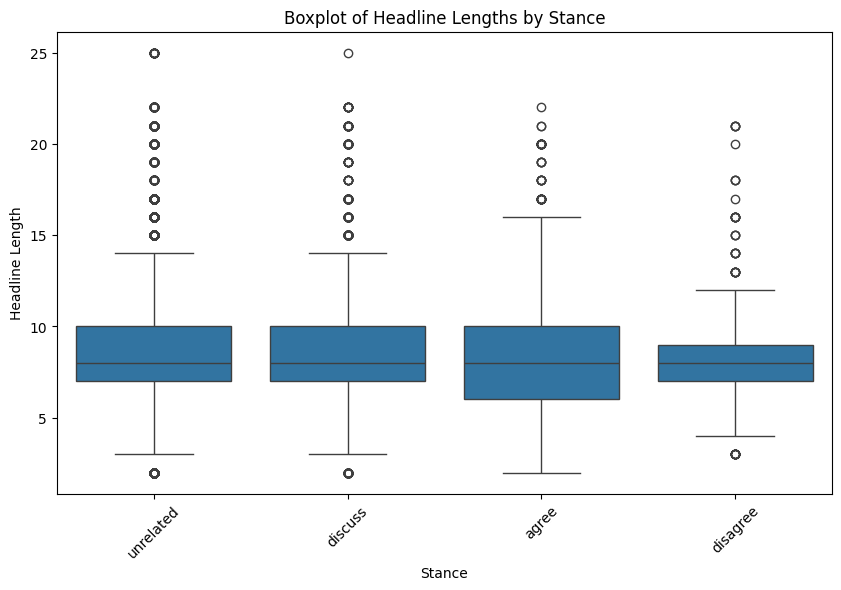

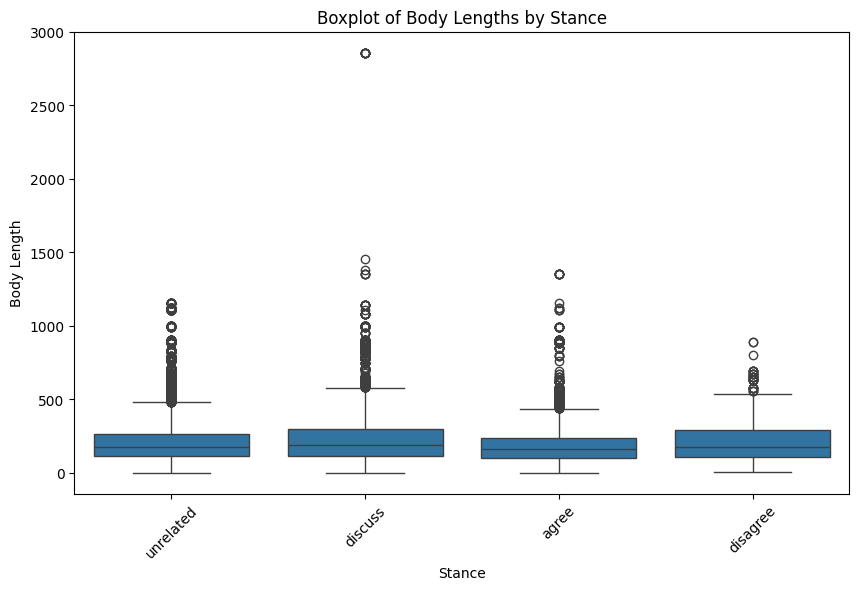

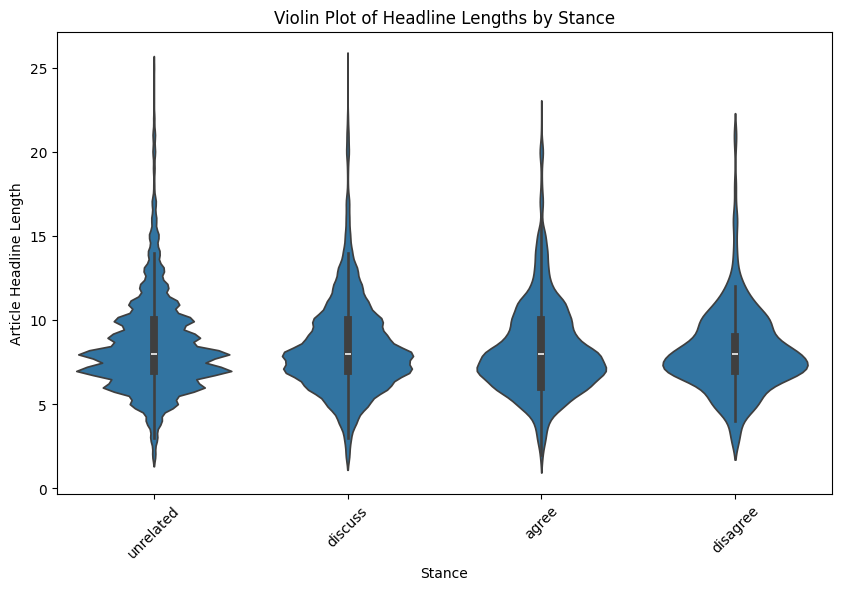

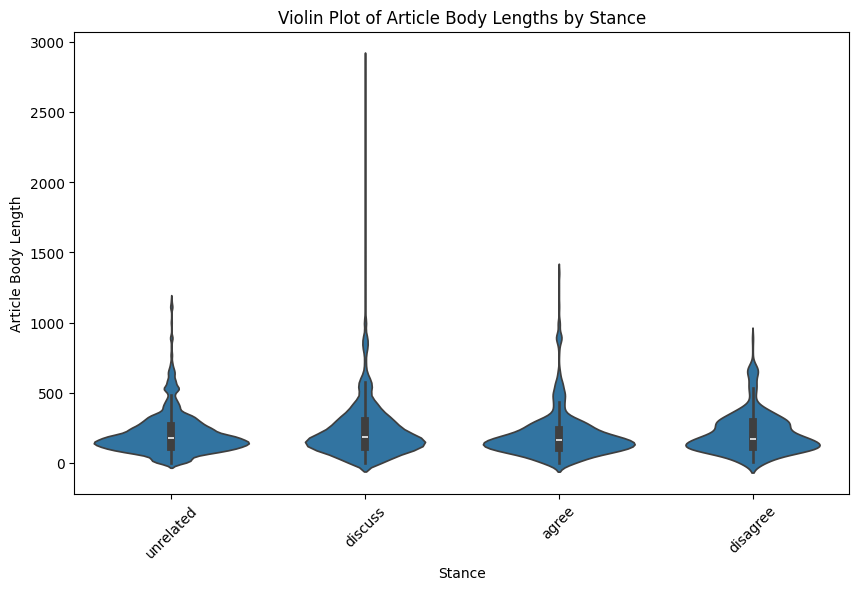

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot for headline lengths
plt.figure(figsize=(10, 6))
sns.boxplot(x='Stance', y='headline_token_count', data=merged_data)
plt.title('Boxplot of Headline Lengths by Stance')
plt.xlabel('Stance')
plt.ylabel('Headline Length')
plt.xticks(rotation=45)
plt.show()

# Boxplot for body lengths
plt.figure(figsize=(10, 6))
sns.boxplot(x='Stance', y='body_token_count', data=merged_data)
plt.title('Boxplot of Body Lengths by Stance')
plt.xlabel('Stance')
plt.ylabel('Body Length')
plt.xticks(rotation=45)
plt.show()

# Violin plot for article body lengths
plt.figure(figsize=(10, 6))
sns.violinplot(x='Stance', y='headline_token_count', data=merged_data)
plt.title('Violin Plot of Headline Lengths by Stance')
plt.xlabel('Stance')
plt.ylabel('Article Headline Length')
plt.xticks(rotation=45)
plt.show()

# Violin plot for article body lengths
plt.figure(figsize=(10, 6))
sns.violinplot(x='Stance', y='body_token_count', data=merged_data)
plt.title('Violin Plot of Article Body Lengths by Stance')
plt.xlabel('Stance')
plt.ylabel('Article Body Length')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Analyze if there's any significant difference in length between stance categories.

### Word Frequency by Stance

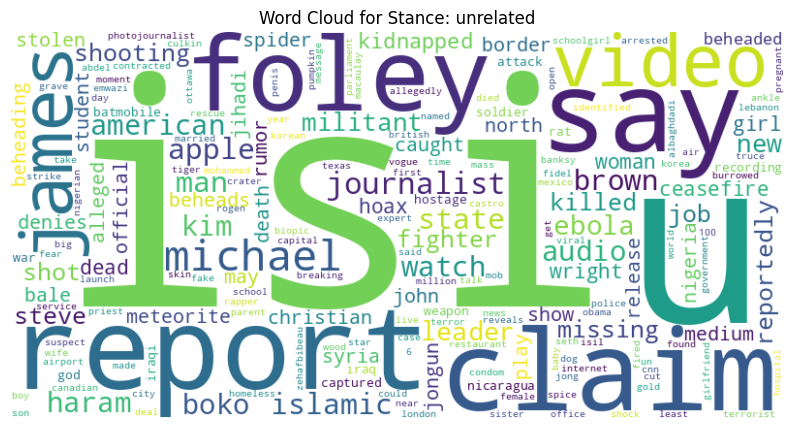

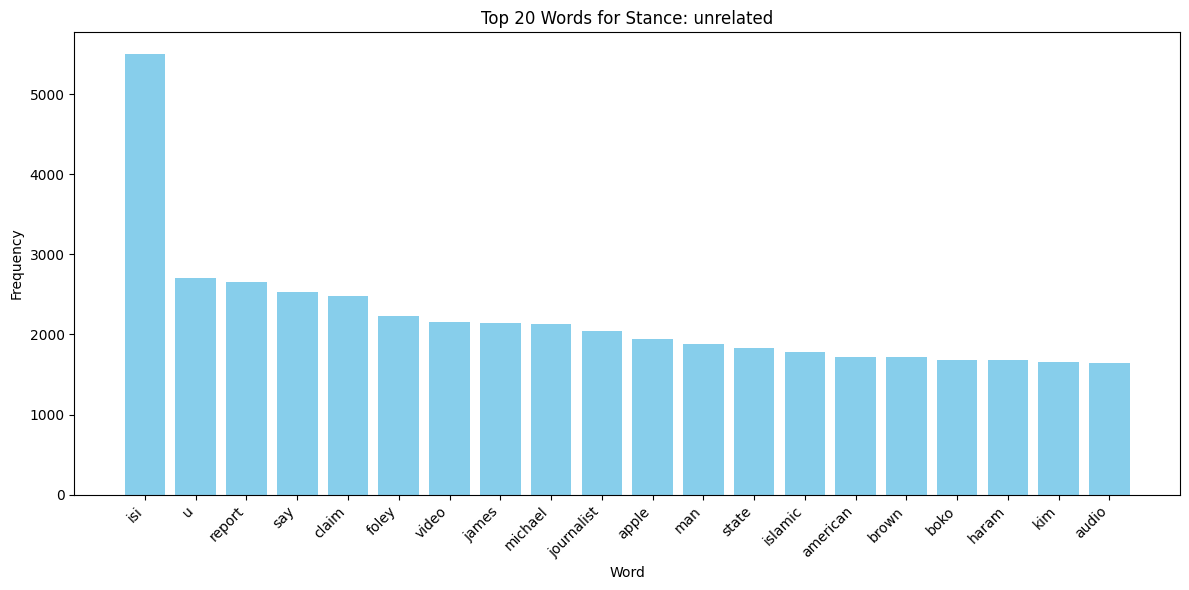

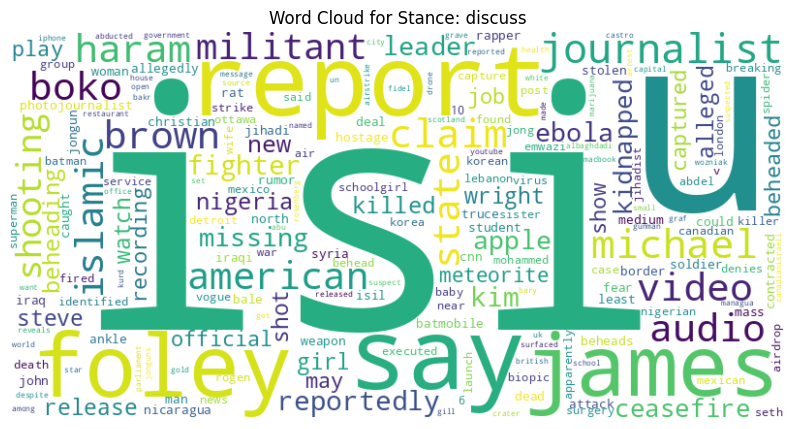

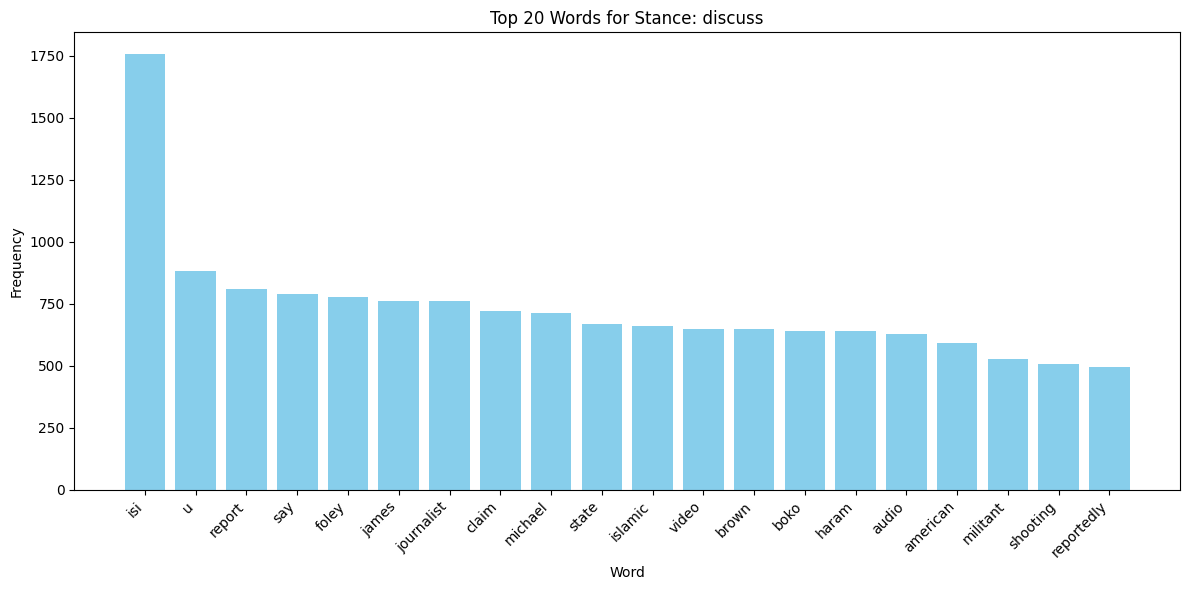

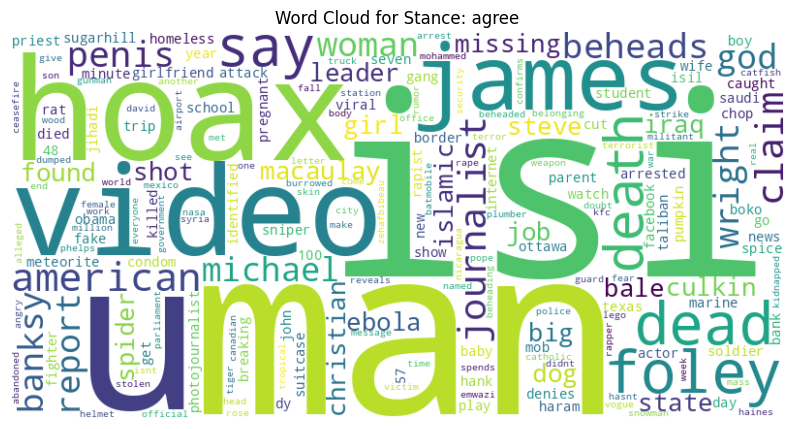

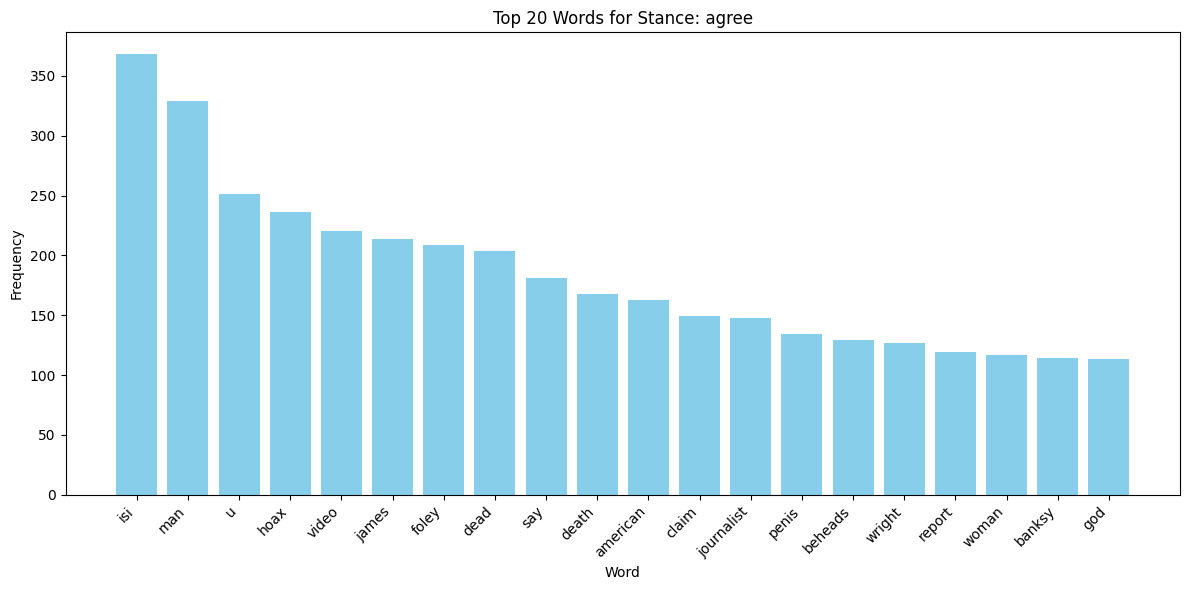

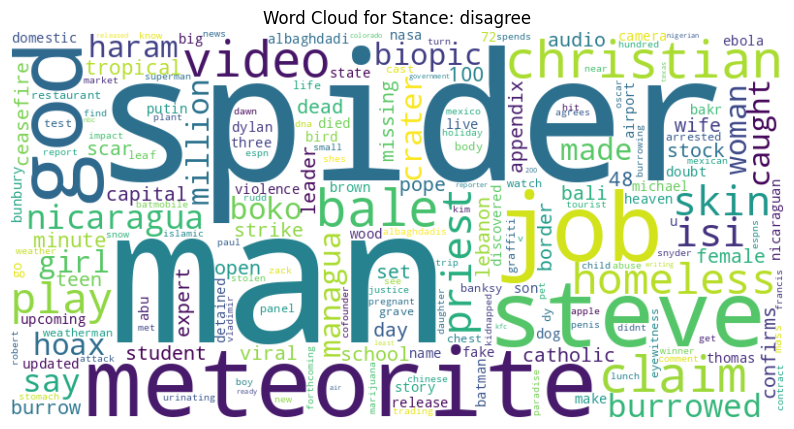

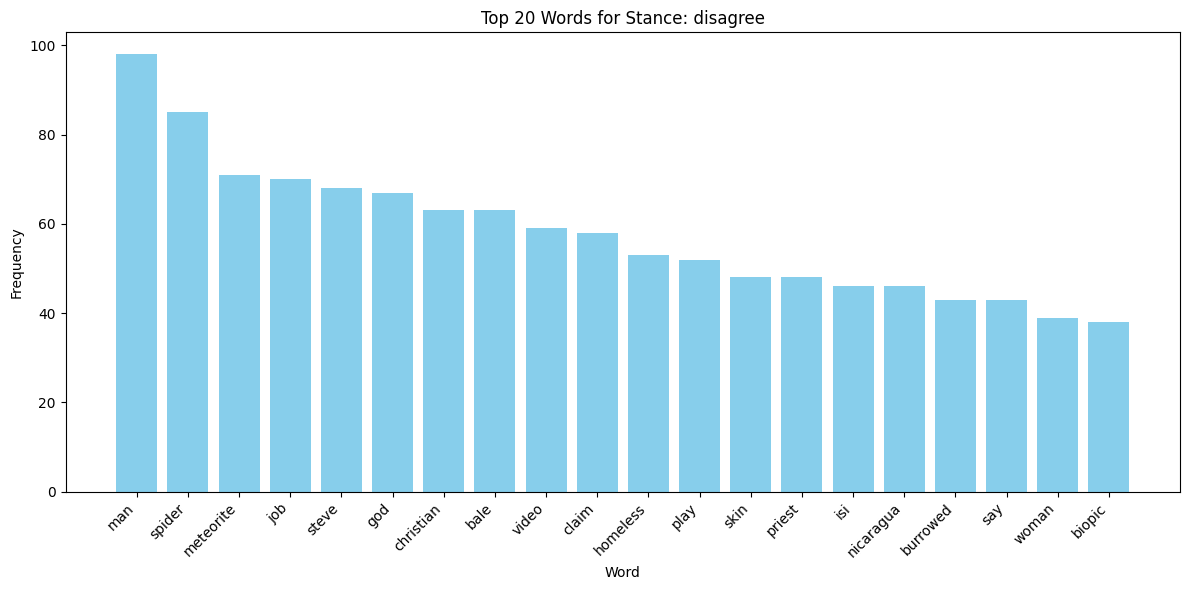

In [ ]:
# Headlines

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Function to count word frequencies and create word cloud
def analyze_word_frequencies_and_create_wordcloud(data, stance):
    # Combine all tokens for the specified stance
    all_tokens = data[data['Stance'] == stance]['headline_tokens'].sum()
    # Count word frequencies
    word_freq = dict()
    for token in all_tokens:
        word_freq[token] = word_freq.get(token, 0) + 1
    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    # Plot word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Stance: {stance}")
    plt.axis('off')
    plt.show()
    # Plot bar chart for top 20 words
    top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]
    plt.figure(figsize=(12, 6))
    plt.bar([word[0] for word in top_words], [word[1] for word in top_words], color='skyblue')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.title(f"Top 20 Words for Stance: {stance}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Analyze word frequencies and create word clouds for each stance category
stances = merged_data['Stance'].unique()
for stance in stances:
    analyze_word_frequencies_and_create_wordcloud(merged_data, stance)


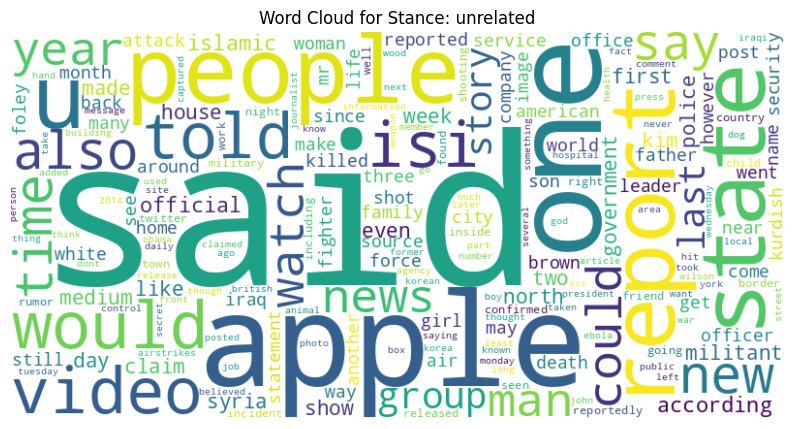

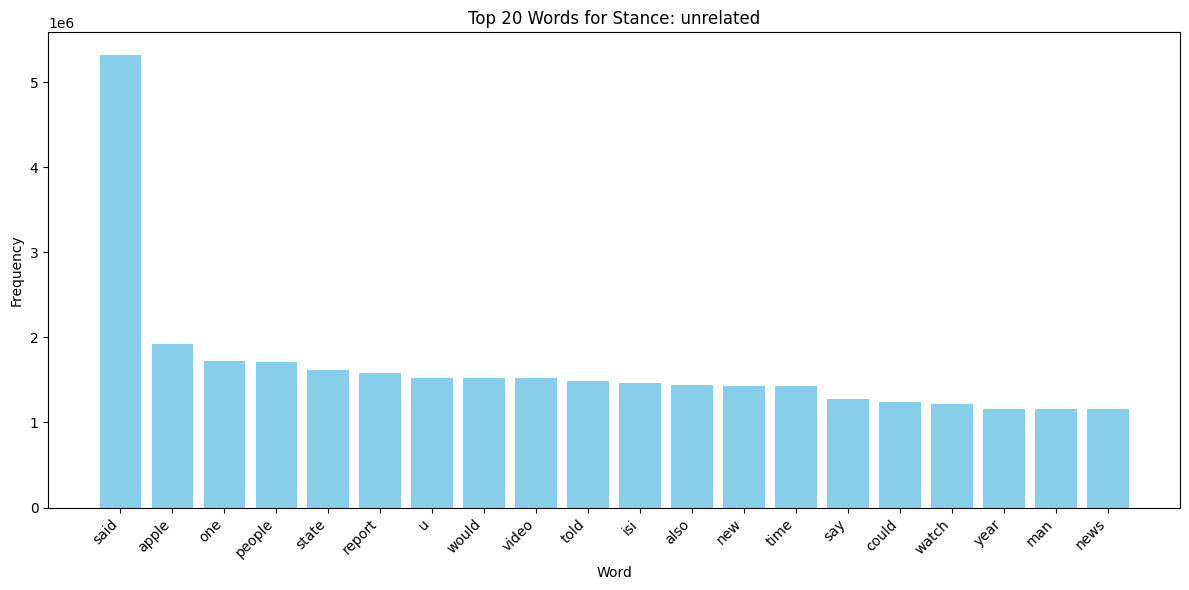

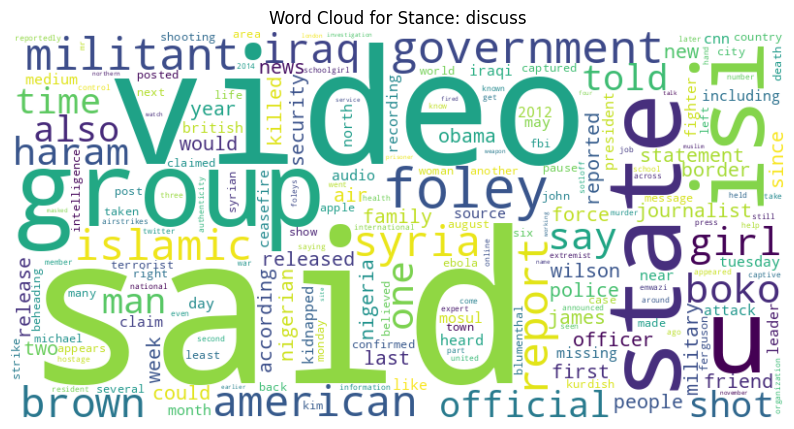

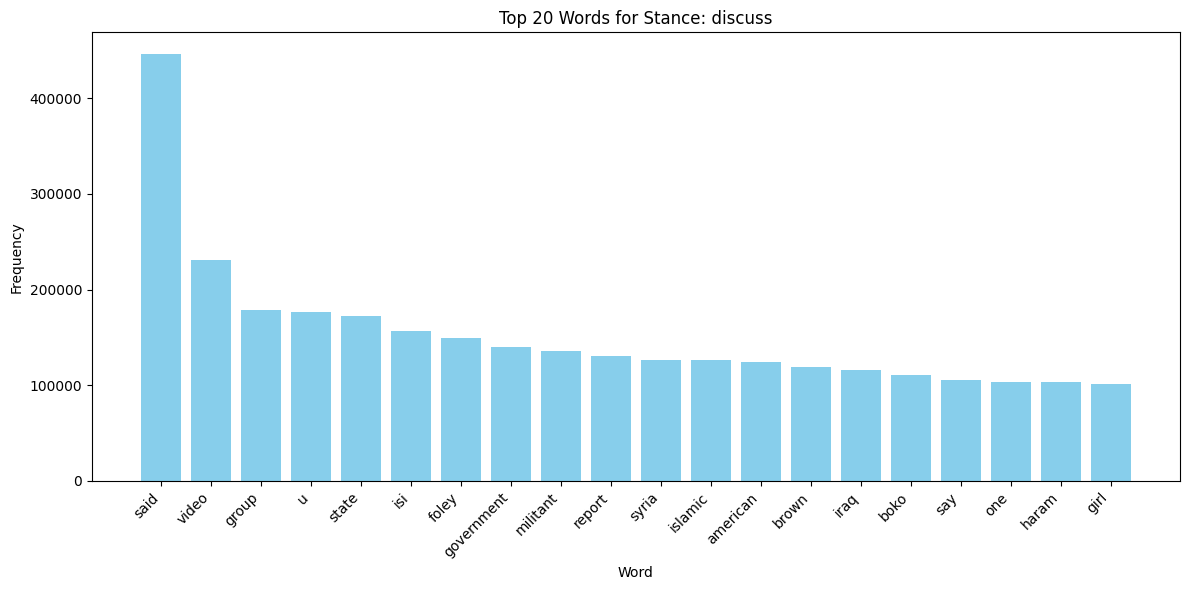

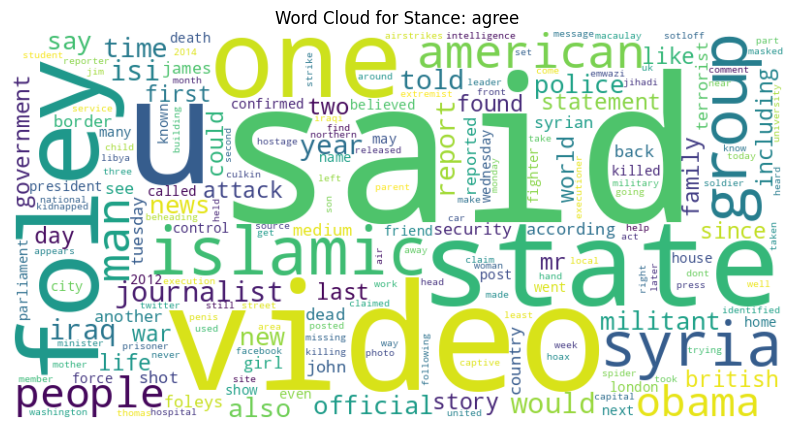

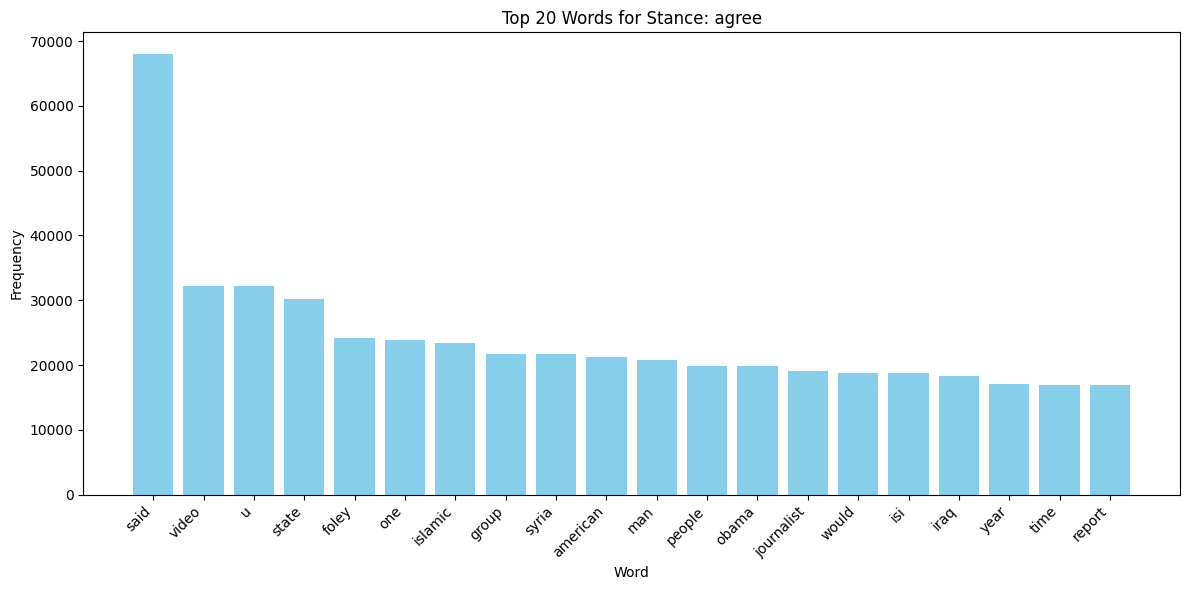

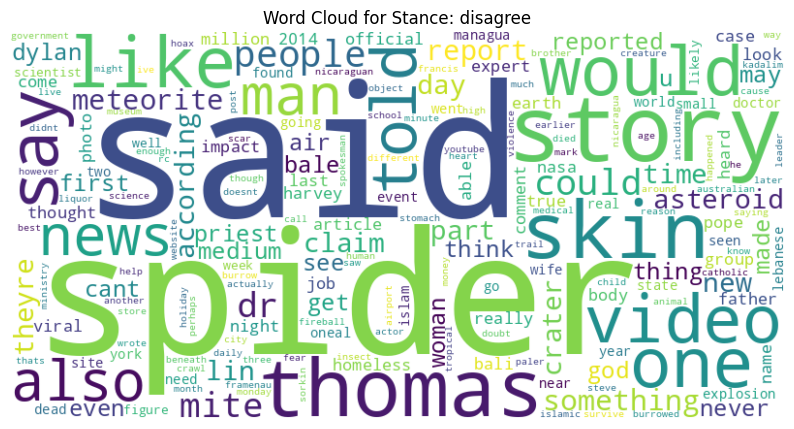

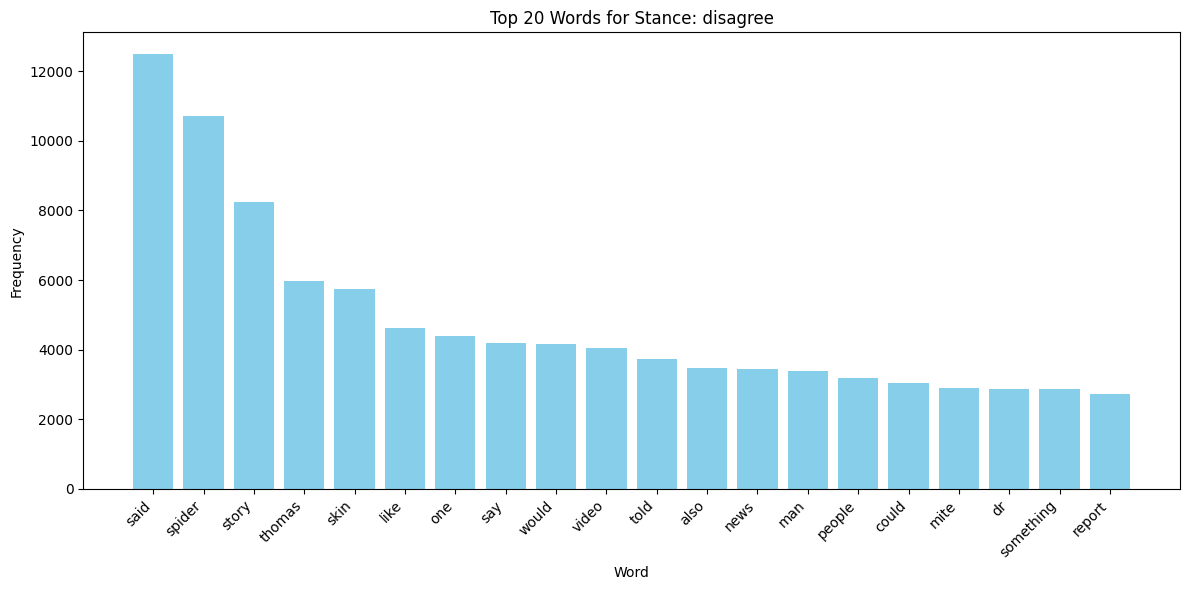

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Initialize cache for word frequencies

# Function to count word frequencies and create word cloud
def analyze_word_frequencies_and_create_wordcloud(data, stance):
    word_freq_cache = dict()

    # Get unique body IDs for the specified stance
    body_ids = data[data['Stance'] == stance]['Body ID'].unique()

    # Iterate over body IDs
    for body_id in body_ids:
        # Check if word frequencies are already calculated for this body ID
        if body_id in word_freq_cache:
            word_freq = word_freq_cache[body_id]
        else:
            # Combine all tokens for the specified body ID
            all_tokens = data[(data['Stance'] == stance) & (data['Body ID'] == body_id)]['body_tokens'].sum()
            # Count word frequencies
            word_freq = dict()
            for token in all_tokens:
                word_freq[token] = word_freq.get(token, 0) + 1
            # Multiply word frequencies by the number of occurrences of the body ID
            num_occurrences = len(data[(data['Stance'] == stance) & (data['Body ID'] == body_id)])
            for token in word_freq:
                word_freq[token] *= num_occurrences
            # Cache word frequencies for reuse
            word_freq_cache[body_id] = word_freq


    word_freq = {}
    for word_freq_value in word_freq_cache.values():
        for token in word_freq_value:
            word_freq[token] = word_freq.get(token, 0) + word_freq_value[token]
    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    # Plot word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Stance: {stance}")
    plt.axis('off')
    plt.show()

    # Plot bar chart for top 20 words
    top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]
    plt.figure(figsize=(12, 6))
    plt.bar([word[0] for word in top_words], [word[1] for word in top_words], color='skyblue')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.title(f"Top 20 Words for Stance: {stance}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Analyze word frequencies and create word clouds for each stance category
stances = merged_data['Stance'].unique()
for stance in stances:
    analyze_word_frequencies_and_create_wordcloud(merged_data, stance)


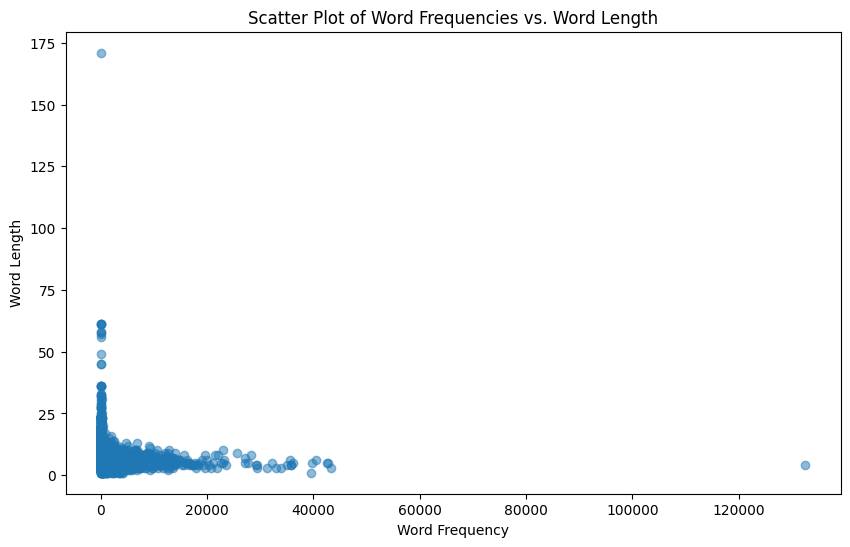

Most frequent word: said, Frequency: 132570
Longest word: jsfjsdgetelementsbytagnames0ifdgetelementbyididreturnjsdcreateelementsjsididjssrcconnectfacebooknetenusalljsxfbml1fjsparentnodeinsertbeforejsfjsdocumentscriptfacebookjssdk, Length: 171


In [ ]:
# Function to create a scatter plot of word frequencies
def create_word_frequency_scatter(data):
    # Get word frequencies
    word_freq = {}
    for tokens in data['body_tokens']:
        for token in tokens:
            word_freq[token] = word_freq.get(token, 0) + 1

    # Extract data for scatter plot
    words = list(word_freq.keys())
    frequencies = list(word_freq.values())

    # Find the most frequent word
    most_frequent_word = max(word_freq, key=word_freq.get)

    # Find the word with the highest length
    longest_word = max(words, key=len)

    # Plot the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(frequencies, [len(word) for word in words], alpha=0.5)
    plt.xlabel('Word Frequency')
    plt.ylabel('Word Length')
    plt.title('Scatter Plot of Word Frequencies vs. Word Length')
    plt.show()

    print(f"Most frequent word: {most_frequent_word}, Frequency: {word_freq[most_frequent_word]}")
    print(f"Longest word: {longest_word}, Length: {len(longest_word)}")

# Create the scatter plot of word frequencies
create_word_frequency_scatter(merged_data)


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to create a co-occurrence network graph
def create_cooccurrence_network(data):
    # Initialize network graph
    G = nx.Graph()

    # Add edges based on word co-occurrence
    for tokens in data['body_tokens']:
        for i in range(len(tokens)):
            for j in range(i+1, len(tokens)):
                if G.has_edge(tokens[i], tokens[j]):
                    G[tokens[i]][tokens[j]]['weight'] += 1
                else:
                    G.add_edge(tokens[i], tokens[j], weight=1)

    # Plot the network graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.1)
    nx.draw(G, pos, node_size=50, with_labels=False)
    plt.title("Co-occurrence Network Graph")
    plt.show()

# Create the co-occurrence network graph
create_cooccurrence_network(merged_data)


KeyboardInterrupt: 

## To Do

Find out to add any new columns